# 10 - Classificando patologias em toras usando combinação de `OTSU_threshold + LBP + SVM`

> considerando as diferentes patologias como uma mesma classe

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.filters import threshold_otsu
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'normal': 0,
                'broca':1,
                'fissura': 2,
                'musgo': 3}

## Processando imagens

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./patologias_toras.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./patologias_toras.zip/{path}')


# Mostrando quantidade de amostras por classe
qtd_amostras_p_classe = []
for target in path_dict:
  n_amostras = len(path_dict[target])
  print(f'{target}: {n_amostras} amostras')

  qtd_amostras_p_classe.append(n_amostras)

N_MIN_DE_AMOSTRAS = min(qtd_amostras_p_classe)
amostra = []

for target_name in TARGET_NAMES:
  path_list = path_dict[target_name]
  path_list_slice = path_list[:N_MIN_DE_AMOSTRAS]
  
  for path in path_list_slice:
    img = io.imread(path, as_gray=True)
    
    img_otsu = img >= threshold_otsu(img)

    lbp = local_binary_pattern(image=img_otsu, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
    
    hist = pd.Series(lbp).value_counts().sort_index()
    arr = np.zeros(59)
    for i in hist.index:
      arr[int(i)] = hist[i]

    df = pd.DataFrame(data=[arr])
    df['target'] = TARGET_NAMES[target_name]
    amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/bin-otsu_lbp_toras.csv')
data

normal: 107 amostras
broca: 90 amostras
fissura: 109 amostras
musgo: 111 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,1156.0,1339.0,0.0,1239.0,0.0,1441.0,0.0,1218.0,0.0,0.0,...,0.0,1008.0,0.0,999.0,0.0,1005.0,0.0,246617.0,9016.0,0
1,947.0,1211.0,0.0,1090.0,0.0,1228.0,0.0,1007.0,0.0,0.0,...,0.0,2372.0,0.0,2127.0,0.0,2150.0,0.0,208973.0,13000.0,0
2,961.0,1310.0,0.0,865.0,0.0,1316.0,0.0,824.0,0.0,0.0,...,0.0,1455.0,0.0,1549.0,0.0,1380.0,0.0,225070.0,9771.0,0
3,918.0,1600.0,0.0,1365.0,0.0,1612.0,0.0,1284.0,0.0,0.0,...,0.0,2873.0,0.0,2995.0,0.0,2847.0,0.0,229565.0,16019.0,0
4,993.0,1836.0,0.0,1646.0,0.0,1818.0,0.0,1592.0,0.0,0.0,...,0.0,3020.0,0.0,3200.0,0.0,3094.0,0.0,217176.0,19958.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,44.0,78.0,0.0,64.0,0.0,83.0,0.0,49.0,0.0,0.0,...,0.0,211.0,0.0,215.0,0.0,185.0,0.0,13171.0,527.0,3
356,43.0,73.0,0.0,79.0,0.0,81.0,0.0,93.0,0.0,0.0,...,0.0,618.0,0.0,729.0,0.0,625.0,0.0,43644.0,997.0,3
357,22.0,41.0,0.0,26.0,0.0,43.0,0.0,27.0,0.0,0.0,...,0.0,110.0,0.0,141.0,0.0,81.0,0.0,22414.0,270.0,3
358,301.0,347.0,0.0,283.0,0.0,346.0,0.0,285.0,0.0,0.0,...,0.0,293.0,0.0,307.0,0.0,290.0,0.0,57361.0,1793.0,3


In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 2992
              precision    recall  f1-score   support

      normal       0.83      0.74      0.78        27
   patologia       0.77      0.85      0.81        27

    accuracy                           0.80        54
   macro avg       0.80      0.80      0.80        54
weighted avg       0.80      0.80      0.80        54



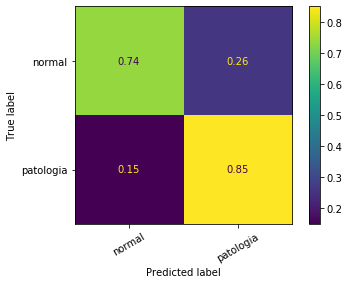

Rodada 1	-	Seed 2405
              precision    recall  f1-score   support

      normal       0.70      0.84      0.76        25
   patologia       0.83      0.69      0.75        29

    accuracy                           0.76        54
   macro avg       0.77      0.76      0.76        54
weighted avg       0.77      0.76      0.76        54



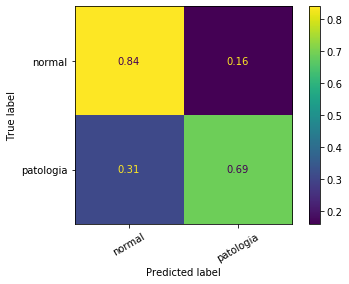

Rodada 2	-	Seed 4036
              precision    recall  f1-score   support

      normal       0.80      0.92      0.86        26
   patologia       0.92      0.79      0.85        28

    accuracy                           0.85        54
   macro avg       0.86      0.85      0.85        54
weighted avg       0.86      0.85      0.85        54



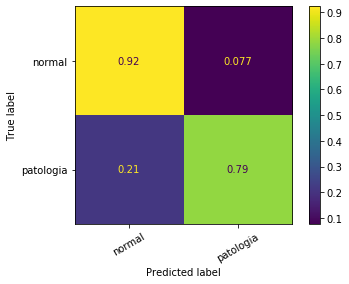

Rodada 3	-	Seed 7895
              precision    recall  f1-score   support

      normal       0.80      0.83      0.82        24
   patologia       0.86      0.83      0.85        30

    accuracy                           0.83        54
   macro avg       0.83      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54



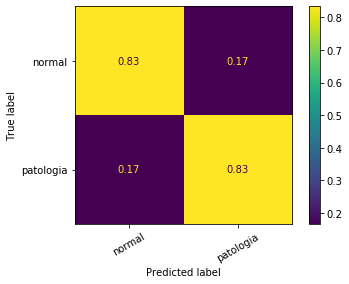

Rodada 4	-	Seed 5582
              precision    recall  f1-score   support

      normal       0.88      0.97      0.92        30
   patologia       0.95      0.83      0.89        24

    accuracy                           0.91        54
   macro avg       0.92      0.90      0.90        54
weighted avg       0.91      0.91      0.91        54



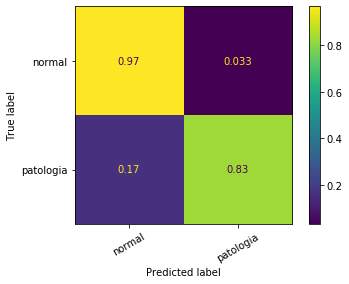

Rodada 5	-	Seed 60
              precision    recall  f1-score   support

      normal       0.84      0.75      0.79        28
   patologia       0.76      0.85      0.80        26

    accuracy                           0.80        54
   macro avg       0.80      0.80      0.80        54
weighted avg       0.80      0.80      0.80        54



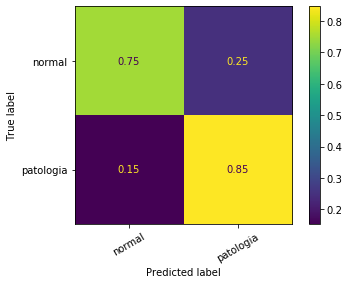

Rodada 6	-	Seed 838
              precision    recall  f1-score   support

      normal       0.89      1.00      0.94        24
   patologia       1.00      0.90      0.95        30

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.94        54
weighted avg       0.95      0.94      0.94        54



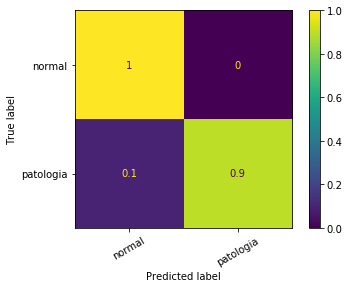

Rodada 7	-	Seed 7952
              precision    recall  f1-score   support

      normal       0.88      0.88      0.88        25
   patologia       0.90      0.90      0.90        29

    accuracy                           0.89        54
   macro avg       0.89      0.89      0.89        54
weighted avg       0.89      0.89      0.89        54



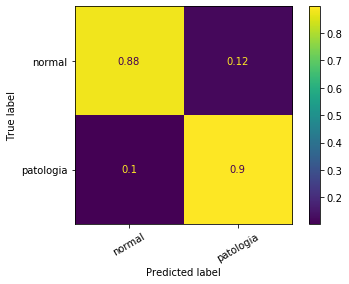

Rodada 8	-	Seed 5630
              precision    recall  f1-score   support

      normal       0.82      0.88      0.85        26
   patologia       0.88      0.82      0.85        28

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.85      0.85      0.85        54



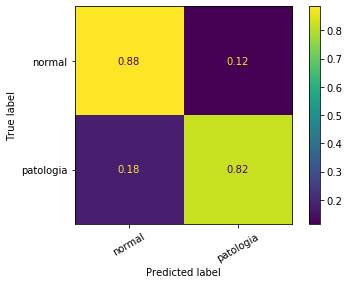

Rodada 9	-	Seed 4022
              precision    recall  f1-score   support

      normal       0.80      0.67      0.73        30
   patologia       0.66      0.79      0.72        24

    accuracy                           0.72        54
   macro avg       0.73      0.73      0.72        54
weighted avg       0.74      0.72      0.72        54



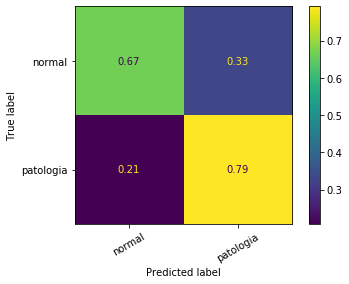

Rodada 10	-	Seed 1232
              precision    recall  f1-score   support

      normal       0.76      0.93      0.84        28
   patologia       0.90      0.69      0.78        26

    accuracy                           0.81        54
   macro avg       0.83      0.81      0.81        54
weighted avg       0.83      0.81      0.81        54



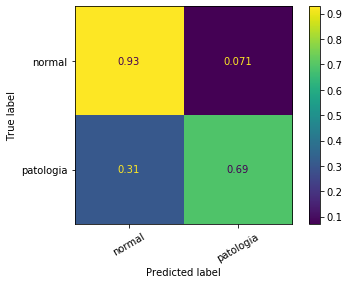

Rodada 11	-	Seed 4976
              precision    recall  f1-score   support

      normal       0.86      0.92      0.89        26
   patologia       0.92      0.86      0.89        28

    accuracy                           0.89        54
   macro avg       0.89      0.89      0.89        54
weighted avg       0.89      0.89      0.89        54



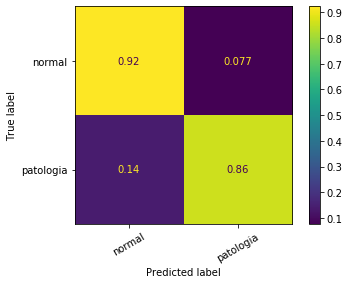

Rodada 12	-	Seed 5852
              precision    recall  f1-score   support

      normal       0.83      0.80      0.81        30
   patologia       0.76      0.79      0.78        24

    accuracy                           0.80        54
   macro avg       0.79      0.80      0.79        54
weighted avg       0.80      0.80      0.80        54



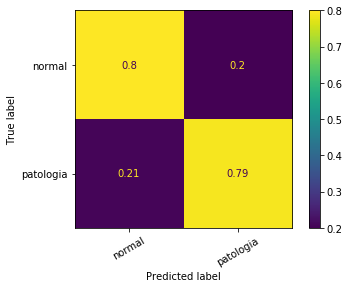

Rodada 13	-	Seed 34
              precision    recall  f1-score   support

      normal       0.94      0.91      0.92        32
   patologia       0.87      0.91      0.89        22

    accuracy                           0.91        54
   macro avg       0.90      0.91      0.90        54
weighted avg       0.91      0.91      0.91        54



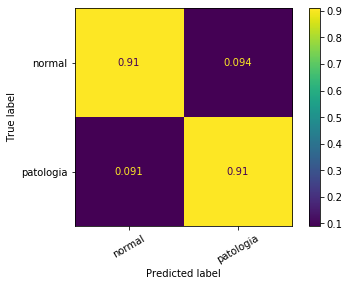

Rodada 14	-	Seed 4498
              precision    recall  f1-score   support

      normal       0.79      0.85      0.81        26
   patologia       0.85      0.79      0.81        28

    accuracy                           0.81        54
   macro avg       0.82      0.82      0.81        54
weighted avg       0.82      0.81      0.81        54



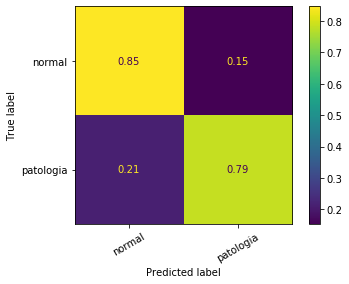

Rodada 15	-	Seed 1883
              precision    recall  f1-score   support

      normal       0.78      0.93      0.85        27
   patologia       0.91      0.74      0.82        27

    accuracy                           0.83        54
   macro avg       0.85      0.83      0.83        54
weighted avg       0.85      0.83      0.83        54



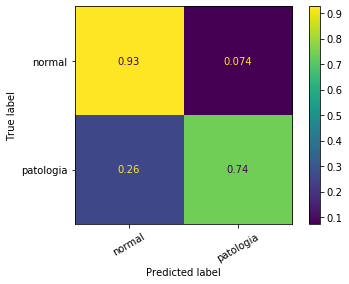

Rodada 16	-	Seed 453
              precision    recall  f1-score   support

      normal       0.79      0.90      0.84        29
   patologia       0.86      0.72      0.78        25

    accuracy                           0.81        54
   macro avg       0.82      0.81      0.81        54
weighted avg       0.82      0.81      0.81        54



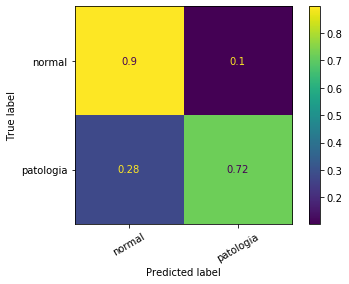

Rodada 17	-	Seed 3774
              precision    recall  f1-score   support

      normal       0.86      0.83      0.84        29
   patologia       0.81      0.84      0.82        25

    accuracy                           0.83        54
   macro avg       0.83      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54



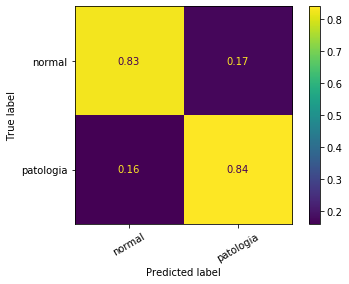

Rodada 18	-	Seed 4441
              precision    recall  f1-score   support

      normal       0.83      0.86      0.85        29
   patologia       0.83      0.80      0.82        25

    accuracy                           0.83        54
   macro avg       0.83      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54



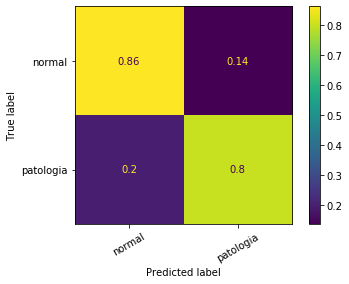

Rodada 19	-	Seed 5255
              precision    recall  f1-score   support

      normal       0.67      0.96      0.79        23
   patologia       0.95      0.65      0.77        31

    accuracy                           0.78        54
   macro avg       0.81      0.80      0.78        54
weighted avg       0.83      0.78      0.78        54



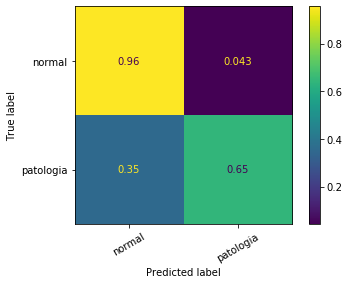

Rodada 20	-	Seed 5760
              precision    recall  f1-score   support

      normal       0.86      0.86      0.86        28
   patologia       0.85      0.85      0.85        26

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.85      0.85      0.85        54



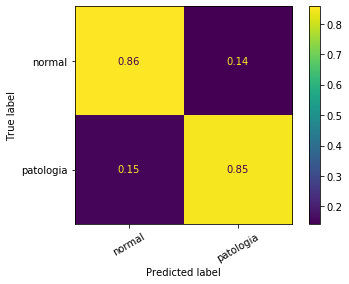

Rodada 21	-	Seed 5054
              precision    recall  f1-score   support

      normal       0.76      0.96      0.85        26
   patologia       0.95      0.71      0.82        28

    accuracy                           0.83        54
   macro avg       0.85      0.84      0.83        54
weighted avg       0.86      0.83      0.83        54



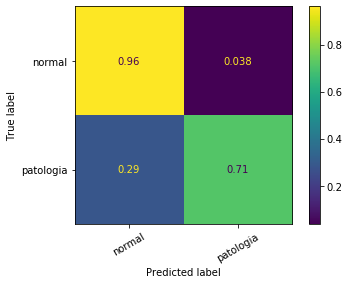

Rodada 22	-	Seed 6346
              precision    recall  f1-score   support

      normal       0.81      0.78      0.79        27
   patologia       0.79      0.81      0.80        27

    accuracy                           0.80        54
   macro avg       0.80      0.80      0.80        54
weighted avg       0.80      0.80      0.80        54



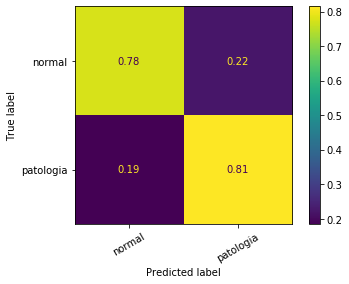

Rodada 23	-	Seed 7580
              precision    recall  f1-score   support

      normal       0.76      1.00      0.86        25
   patologia       1.00      0.72      0.84        29

    accuracy                           0.85        54
   macro avg       0.88      0.86      0.85        54
weighted avg       0.89      0.85      0.85        54



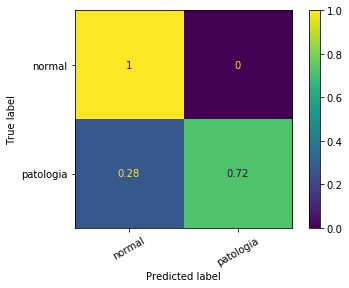

Rodada 24	-	Seed 2046
              precision    recall  f1-score   support

      normal       0.81      0.75      0.78        28
   patologia       0.75      0.81      0.78        26

    accuracy                           0.78        54
   macro avg       0.78      0.78      0.78        54
weighted avg       0.78      0.78      0.78        54



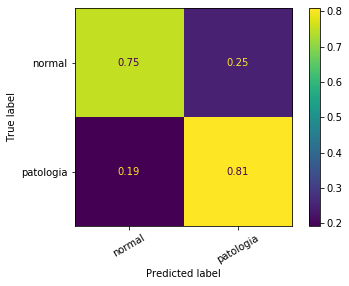

Rodada 25	-	Seed 4501
              precision    recall  f1-score   support

      normal       0.91      0.86      0.88        35
   patologia       0.76      0.84      0.80        19

    accuracy                           0.85        54
   macro avg       0.84      0.85      0.84        54
weighted avg       0.86      0.85      0.85        54



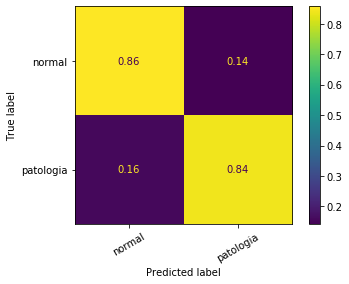

Rodada 26	-	Seed 4029
              precision    recall  f1-score   support

      normal       0.89      0.75      0.81        32
   patologia       0.70      0.86      0.78        22

    accuracy                           0.80        54
   macro avg       0.80      0.81      0.79        54
weighted avg       0.81      0.80      0.80        54



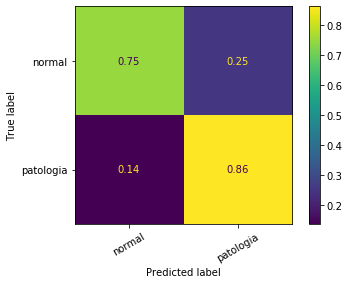

Rodada 27	-	Seed 4382
              precision    recall  f1-score   support

      normal       0.89      0.97      0.93        32
   patologia       0.95      0.82      0.88        22

    accuracy                           0.91        54
   macro avg       0.92      0.89      0.90        54
weighted avg       0.91      0.91      0.91        54



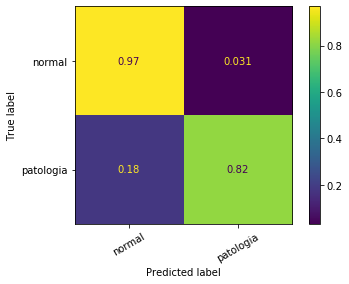

Rodada 28	-	Seed 6987
              precision    recall  f1-score   support

      normal       0.93      0.87      0.90        31
   patologia       0.84      0.91      0.87        23

    accuracy                           0.89        54
   macro avg       0.89      0.89      0.89        54
weighted avg       0.89      0.89      0.89        54



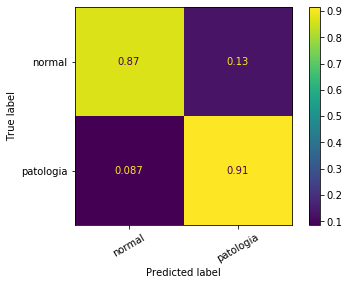

Rodada 29	-	Seed 1662
              precision    recall  f1-score   support

      normal       0.74      0.93      0.82        27
   patologia       0.90      0.67      0.77        27

    accuracy                           0.80        54
   macro avg       0.82      0.80      0.79        54
weighted avg       0.82      0.80      0.79        54



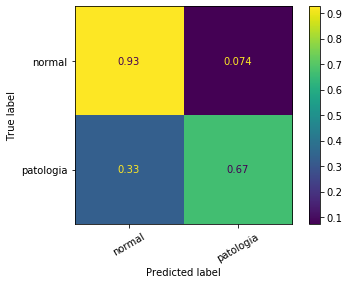

In [4]:
TARGET_NAMES = ['normal', 'patologia']
df = pd.read_csv('./csvs/bin-lbp_toras.csv')

df_list = []
for target, dataframe in df.groupby('target'):
  l = len(dataframe)
  if target != 0:
    l //= 3
  df_list.append(dataframe.head(l))

df = pd.concat(df_list, ignore_index=True)
y = df.pop('target').values

# valores em y diferentes de 0 se tornam 1
y[y!=0] = 1
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

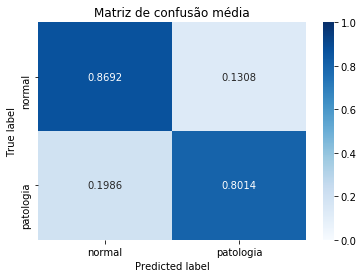

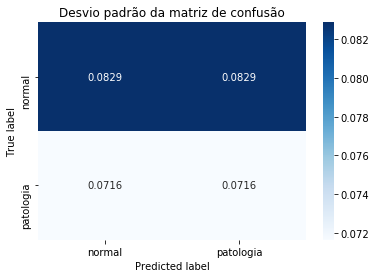

In [5]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia  f1-normal  f1-patologia
count  30.000000  30.000000     30.000000
mean    0.833951   0.841691      0.823017
std     0.050184   0.051596      0.051306
min     0.722222   0.727273      0.716981
25%     0.796296   0.813559      0.782609
50%     0.833333   0.844781      0.816327
75%     0.851852   0.875517      0.850753
max     0.944444   0.941176      0.947368


Acurácia,f1-normal,f1-patologia
0.796296,0.784314,0.807018
0.759259,0.763636,0.754717
0.851852,0.857143,0.846154
0.833333,0.816327,0.847458
0.907407,0.920635,0.888889
0.796296,0.792453,0.800000
0.944444,0.941176,0.947368
0.888889,0.880000,0.896552
0.851852,0.851852,0.851852
0.722222,0.727273,0.716981


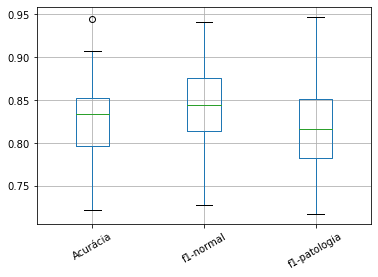

In [6]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot(rot=30)

acc_df.style.hide_index().background_gradient(cmap='Blues')